# Hessian-based uncertainty quantification

**Author:** James R. Maddison

This notebook describes the use of tlm_adjoint for Hessian-based uncertainty quantification. The approach is based on the method described in

- Tobin Isaac, Noemi Petra, Georg Stadler, and Omar Ghattas, 'Scalable and efficient algorithms for the propagation of uncertainty from data through inference to prediction for large-scale problems, with application to flow of the Antarctic ice sheet', Journal of Computational Physics, 296, pp. 348&ndash;368, 2015, doi: 10.1016/j.jcp.2015.04.047

We assume real spaces and a real build of Firedrake throughout.

## Uncertainty quantification problem

We consider the advection-diffusion equation in the unit square domain

$$\partial_t u + \nabla^\perp m \cdot \nabla u = \kappa \nabla^2 u,$$

for some real and positive $\kappa$ and subject to doubly periodic boundary conditions. We consider a continuous Galerkin finite element discretization in space and an implicit midpoint rule discretization in time, seeking $u_{n + 1} \in V$ such that

$$\forall \zeta \in V \qquad \int_\Omega \zeta u_{n + 1} + \Delta t \int_\Omega \zeta \nabla^\perp m \cdot \nabla \left[ \frac{1}{2} ( u_n + u_{n + 1}) \right]
    + \kappa \Delta t \int_\Omega \nabla \zeta \cdot \nabla \left[ \frac{1}{2} ( u_n + u_{n + 1}) \right] = \int_\Omega \zeta u_n,$$

with timestep size $\Delta t$ and given some suitable discrete initial condition $u_0 \in V$. Here $V$ is a real continuous $P_1$ finite element space whose elements satisfy the doubly periodic boundary conditions, and after discretizing we have $m \in V$. For a given value of $m$ we let $\hat{u}_N ( m )$ denote the solution obtained after $N$ timesteps. Given an observation for $\hat{u}_N ( t )$, $u_{obs} \in V$, we seek to infer information about the control $m$. Here we are specifically seeking to infer the transport, defined in terms of a stream function $m$, which transports the solution from $u_0$ to $u_{obs}$ in time $T$.

We first need to model the observational error. For a given value of the control $m$ we treat observations are being realizations of a Gaussian random variable, with mean given by $\hat{u}_N ( m )$, and with known covariance. Specifically we define a density $p ( u_{obs} | m )$ whose negative logarithm is (up to a normalization term which is neglected here)

$$-\ln p ( u_{obs} | m ) = \frac{1}{2} R_{obs}^{-1} ( u_{obs} - \hat{u}_N ( m ), u_{obs} - \hat{u}_N ( m ) ).$$

$R_{obs}^{-1}$ is a bilinear and symmetric positive definite observational inverse covariance operator. Here we choose $R_{obs}^{-1}$ by defining

$$R_{obs}^{-1} ( q_i, q_j ) = \int_\Omega q_j \mathcal{L}_{\sigma_R,d_R}^2 ( q_i ),$$

where $\mathcal{L}_{\sigma,d} : V \rightarrow V$ is defined by

$$\forall \zeta \in V \qquad \frac{1}{\sqrt{4 \pi \sigma^2}} \left[ \frac{1}{d} \int_\Omega \zeta q + d \int_\Omega \nabla \zeta \cdot \nabla q \right] = \int_\Omega \zeta \mathcal{L}_{\sigma,d} \left( q \right).$$

In the continuous and $\Omega = \mathbb{R}^2$ case $R_{obs}$ then defines a covariance operator with single point variance $\sigma_R^2$ and autocorrelation length scale $d_R$ (see Lindgren et al 2011, doi: 10.1111/j.1467-9868.2011.00777.x).

We next introduce a prior for the control. We consider a Gaussian prior with mean zero and with known covariance. Specifically we define a prior density $p ( m )$ whose negative logarithm is (again up to a normalization term)

$$-\ln p ( m ) = \frac{1}{2} B^{-1} ( m, m ).$$

$B^{-1}$ is a bilinear and symmetric positive definite observational inverse covariance operator. Here we choose $B^{-1}$ by defining

$$B^{-1} ( q_i, q_j ) = \int_\Omega q_j \mathcal{L}_{\sigma_B,d_B}^2 ( q_i ).$$

Now applying Bayes theorem we obtain a posterior density whose negative logarithm is (up to a normalization term)

$$-\ln p ( m | u_{obs} ) = \frac{1}{2} R_{obs}^{-1} ( u_{obs} - \hat{u}_N ( m ), u_{obs} - \hat{u}_N ( m ) ) + \frac{1}{2} B^{-1} ( m, m ).$$

We have made a number of modelling choices, but subject to these choices the posterior density now completely describes the information we have about the control after being supplied with an observation $u_{obs}$. The challenge is that the posterior is defined in a high dimensional space, and is in general not Gaussian. To simplify the problem we *approximate* the posterior with a Gaussian, and specifically make the approximation (up to a normalization term)

$$-\ln p ( m | u_{obs} ) \approx \frac{1}{2} \Gamma_{post}^{-1} ( m - m_{MAP}, m - m_{MAP} ).$$

The mean of the Gaussian approximation is set equal to the posterior density maximizer (the Maximum A Posteriori estimate), $m_{map}$. The inverse covariance of the Gaussian approximation, $\Gamma_{post}^{-1}$, is set equal to the Hessian, $H$, of the negative log posterior density $-\ln p ( m | u_{obs} )$, defined by differentiating twice with respect to $m$ and evaluated at the posterior density maximizer.

Unfortunately in order to quantify uncertainty we require information about the *covariance*, and not the *inverse covariance*. Specifically if we have a linear observational operator $q \in V^*$ then our estimate for the variance associated with $q ( m )$ is

$$\sigma^2_q \approx \Gamma_{post} ( q, q ) = H^{-1} ( q, q ),$$

which requires access to information about the Hessian *inverse*.

In the following we use two approaches to gain access to this information.

1. A low rank update approximation. We approximate the Hessian inverse using a low rank update to the prior covariance, using the methodology of Isaac et al 2015, doi: 10.1016/j.jcp.2015.04.047.
2. By computing the Hessian inverse action using a Krylov method, preconditioned using the low rank update approximation.

To solve this problem we need several pieces:

1. A differentiable solver for the forward problem. We will construct this using Firedrake with tlm_adjoint.
2. To find the posterior maximizer. We will use gradient-based optimization using TAO.
3. To find a low rank update approximation for the Hessian inverse. We will find this using a partial eigenspectrum obtained using SLEPc.
4. To compute the Hessian inverse action. We will compute this using a Krylov method using PETSc, preconditioned using the partial eigenspectrum.

## Forward problem

We first implement the forward model using Firedrake with tlm_adjoint.

In [1]:
%matplotlib inline

from firedrake import *
from tlm_adjoint.firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

reset_manager()
clear_caches()

mesh = PeriodicUnitSquareMesh(40, 40, diagonal="crossed")
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test = TestFunction(space)
trial = TrialFunction(space)

T = 0.5
N = 10
kappa = Constant(1.0e-3, static=True)
dt = Constant(T / N, static=True)
sigma_R = Constant(0.03)
d_R = Constant(0.1)
sigma_B = Constant(0.025)
d_B = Constant(0.2)
u_0 = Function(space, name="u_0").interpolate(
    exp(-((X[0] - 0.4) ** 2 + (X[1] - 0.5) ** 2) / (2 * 0.08 * 0.08)))
u_obs = Function(space, name="u_obs").interpolate(
    exp(-((X[0] - 0.6) ** 2 + (X[1] - 0.5) ** 2) / (2 * 0.08 * 0.08)))


def L(sigma, d, q):
    u = Function(space)
    solve(inner(trial, test) * dx
          == (1.0 / sqrt(4.0 * np.pi * sigma * sigma))
          * ((1.0 / d) * inner(q, test) * dx + d * inner(grad(q), grad(test)) * dx),
          u, solver_parameters={"ksp_type": "preonly",
                                "pc_type": "cholesky"})
    return u


def L_inv(sigma, d, q):
    u = Function(space)
    solve((1.0 / sqrt(4.0 * np.pi * sigma * sigma))
          * ((1.0 / d) * inner(trial, test) * dx + d * inner(grad(trial), grad(test)) * dx)
          == inner(q, test) * dx,
          u, solver_parameters={"ksp_type": "preonly",
                                "pc_type": "cholesky"})
    return u


def R_inv_term(q):
    L_q = L(sigma_R, d_R, q)
    LL_q = L(sigma_R, d_R, L_q)
    return Functional(name="J_mismatch").assign(0.5 * inner(LL_q, q) * dx)


def R_inv_action(q):
    L_q = L(sigma_R, d_R, q)
    LL_q = L(sigma_R, d_R, L_q)
    return assemble(inner(LL_q, test) * dx)


def B_inv_term(q):
    L_q = L(sigma_B, d_B, q)
    LL_q = L(sigma_B, d_B, L_q)
    return Functional(name="J_prior").assign(0.5 * inner(LL_q, q) * dx)


def B_inv_action(q):
    L_q = L(sigma_B, d_B, q)
    LL_q = L(sigma_B, d_B, L_q)
    return assemble(inner(LL_q, test) * dx)


def B_action(q):
    u = Function(space)
    solve(inner(trial, test) * dx == q,
          u, solver_parameters={"ksp_type": "preonly",
                                "pc_type": "cholesky"})
    Li_q = L_inv(sigma_B, d_B, u)
    LiLi_q = L_inv(sigma_B, d_B, Li_q)
    return LiLi_q


def forward(m):
    m = Function(space, cache=True).assign(m)
    u_np1 = Function(space, name="u_np1")
    u_n = u_0.copy(deepcopy=True)
    eq = EquationSolver(inner(trial, test) * dx
                        + 0.5 * dt * inner(dot(perp(grad(m)), grad(trial)), test) * dx
                        + 0.5 * kappa * dt * inner(grad(trial), grad(test)) * dx
                        == inner(u_n, test) * dx
                        - 0.5 * dt * inner(dot(perp(grad(m)), grad(u_n)), test) * dx
                        - 0.5 * kappa * dt * inner(grad(u_n), grad(test)) * dx,
                        u_np1, solver_parameters={"ksp_type": "preonly",
                                                  "pc_type": "lu"})
    for _ in range(N):
        eq.solve()
        u_n.assign(u_np1)

    u_mismatch = Function(space, name="u_mismatch").assign(u_n - u_obs)
    J_mismatch = R_inv_term(u_mismatch)
    J_prior = B_inv_term(m)
    return J_mismatch, J_prior, J_mismatch + J_prior, u_np1

Let's first visualize the initial condition $u_0$ and the observation $u_{obs}$ taken a time $T$ later.

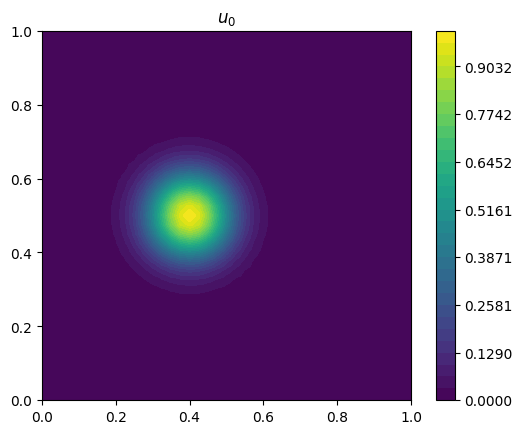

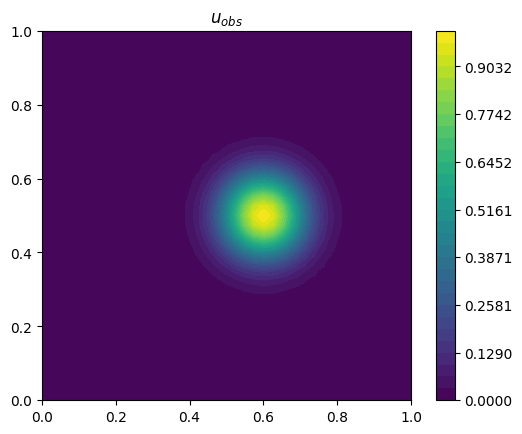

In [2]:
def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u_0, r"$u_0$")
plot_output(u_obs, r"$u_{obs}$")

## Quantities of interest

In the following discussion we seek to quantify uncertainties in *quantities of interest*. These are defined using linear functionals, say $q \in V^*$. Given some value of the control $m$, $q ( m )$ is the value of the quantity of interest. Moreover, given the Maximum A Posteriori estimate $m_{map}$ for the control (the posterior density maximizer), the estimate for the posterior mean of the quantity of interest is given by

$$\mu_{q,posterior} \approx q ( m_{map} ).$$

To obtain uncertainty estimates we need a covariance operator. Note that a covariance operator, say $\Gamma_{post}$, is a bilinear operator, $\Gamma_{post} : V^* \times V^* \rightarrow \mathbb{R}$. It takes the linear functionals we use to obtain values for two quantities of interest, and gives us a value for a covariance between them. In particular the estimate for the posterior uncertainty in a single quantity of interest, defined by a linear functional $q \in V^*$, is

$$\sigma_{q,posterior} \approx \sqrt{ \Gamma_{post} ( q, q ) } = \sqrt{ H^{-1} ( q, q ) }.$$

## Finding the posterior maximizer

We now find the posterior density maximizer, which corresponds to seeking a minimum of the negative log posterior density. We solve this problem using the Toolkit for Advanced Optimization (TAO), with the Limited-Memory Variable Metric (LMVM) approach. This is a gradient-based approach, so let's first verify the adjoint using Taylor verification.

In [3]:
m_0 = Function(space, name="m_0").interpolate(
    0.06 * sin(2 * pi * X[1]))

reset_manager()
start_manager()
_, _, J, _ = forward(m_0)
stop_manager()

dJ = compute_gradient(J, m_0)
dm = Function(space, name="dm").interpolate(
    sin(4 * pi * X[0]) * cos(6 * pi * X[1]))
min_order = taylor_test(lambda m: forward(m)[2], m_0, J_val=J.value, dJ=dJ, dM=dm, seed=1.0e-6)
assert min_order > 1.99

Error norms, no adjoint   = [1.53027865e-04 7.39407643e-05 3.63270898e-05 1.80027218e-05
 8.96115500e-06]


Orders,      no adjoint   = [1.04935252 1.02532416 1.01283075 1.00645844]


Error norms, with adjoint = [1.02926724e-05 2.57316785e-06 6.43291602e-07 1.60822709e-07
 4.02054503e-08]


Orders,      with adjoint = [2.00000013 2.00000081 2.00000172 2.00000815]


Next we solve the optimization problem. The considered problem seeks to infer the transport in the advection-diffusion equation, in terms of a stream function. Initially the tracer is concentrated on the left, and the observation taken a time $T$ later has the tracer moved to the right. The variable `m_0`, which will define our initial guess for the optimization, is set so that the velocity at the center has approximately the correct magnitude for this transport.

As usual we need to define an appropriate inner product associated with derivatives. Here the prior defines a natural inner product &ndash; specifically we can use the prior covariance, $B$, to define an inner product for the dual space $V^*$.

In [4]:
optimizer = TAOSolver(lambda m: forward(m)[2], space, H_0_action=B_action,
                      solver_parameters={"tao_type": "lmvm",
                                         "tao_gatol": 1.0e-5,
                                         "tao_grtol": 0.0,
                                         "tao_gttol": 0.0,
                                         "tao_monitor": None})

m_map = Function(space, name="m_map").assign(m_0)
optimizer.solve(m_map)

reset_manager()
start_manager()
J_mismatch, _, J, u_map = forward(m_map)
stop_manager()

  Iteration information for _tlm_adjoint__Tao_0xc4000003_0_ solve.
  0 TAO,  Function value: 142.531,  Residual: 252.076 


  1 TAO,  Function value: 75.6093,  Residual: 78.5923 


  2 TAO,  Function value: 68.3955,  Residual: 48.098 


  3 TAO,  Function value: 64.8572,  Residual: 33.5383 


  4 TAO,  Function value: 60.3369,  Residual: 27.2206 


  5 TAO,  Function value: 58.3236,  Residual: 25.1547 


  6 TAO,  Function value: 56.863,  Residual: 15.66 


  7 TAO,  Function value: 56.2613,  Residual: 23.2133 


  8 TAO,  Function value: 56.0512,  Residual: 29.4124 


  9 TAO,  Function value: 55.5922,  Residual: 25.9102 


 10 TAO,  Function value: 54.986,  Residual: 29.7655 


 11 TAO,  Function value: 54.6658,  Residual: 27.5321 


 12 TAO,  Function value: 54.0866,  Residual: 31.1733 


 13 TAO,  Function value: 53.6629,  Residual: 27.9583 


 14 TAO,  Function value: 53.4698,  Residual: 24.8065 


 15 TAO,  Function value: 53.1749,  Residual: 22.2047 


 16 TAO,  Function value: 53.0568,  Residual: 22.6377 


 17 TAO,  Function value: 52.6485,  Residual: 17.693 


 18 TAO,  Function value: 52.3048,  Residual: 20.5252 


 19 TAO,  Function value: 51.9384,  Residual: 18.2042 


 20 TAO,  Function value: 51.6112,  Residual: 12.7694 


 21 TAO,  Function value: 51.2598,  Residual: 16.009 


 22 TAO,  Function value: 50.8641,  Residual: 13.3265 


 23 TAO,  Function value: 50.6379,  Residual: 13.2171 


 24 TAO,  Function value: 50.4164,  Residual: 15.321 


 25 TAO,  Function value: 49.9947,  Residual: 10.4495 


 26 TAO,  Function value: 49.7759,  Residual: 9.19296 


 27 TAO,  Function value: 49.6278,  Residual: 13.802 


 28 TAO,  Function value: 49.5019,  Residual: 10.8119 


 29 TAO,  Function value: 49.4283,  Residual: 11.1461 


 30 TAO,  Function value: 49.3206,  Residual: 11.6553 


 31 TAO,  Function value: 49.2344,  Residual: 13.5738 


 32 TAO,  Function value: 49.0752,  Residual: 12.4629 


 33 TAO,  Function value: 48.9742,  Residual: 12.9785 


 34 TAO,  Function value: 48.8608,  Residual: 9.69846 


 35 TAO,  Function value: 48.7065,  Residual: 12.143 


 36 TAO,  Function value: 48.653,  Residual: 11.1146 


 37 TAO,  Function value: 48.5809,  Residual: 14.2326 


 38 TAO,  Function value: 48.5129,  Residual: 13.3145 


 39 TAO,  Function value: 48.4525,  Residual: 13.0799 


 40 TAO,  Function value: 48.3492,  Residual: 8.95482 


 41 TAO,  Function value: 48.3188,  Residual: 10.6709 


 42 TAO,  Function value: 48.2868,  Residual: 9.38934 


 43 TAO,  Function value: 48.2554,  Residual: 8.40332 


 44 TAO,  Function value: 48.2185,  Residual: 8.02572 


 45 TAO,  Function value: 48.1992,  Residual: 7.70232 


 46 TAO,  Function value: 48.1456,  Residual: 5.1021 


 47 TAO,  Function value: 48.1372,  Residual: 5.88148 


 48 TAO,  Function value: 48.1283,  Residual: 5.77235 


 49 TAO,  Function value: 48.1185,  Residual: 6.27168 


 50 TAO,  Function value: 48.1009,  Residual: 7.03941 


 51 TAO,  Function value: 48.0807,  Residual: 6.32074 


 52 TAO,  Function value: 48.0587,  Residual: 5.77033 


 53 TAO,  Function value: 48.0507,  Residual: 5.9735 


 54 TAO,  Function value: 48.0441,  Residual: 6.11227 


 55 TAO,  Function value: 48.0354,  Residual: 5.9437 


 56 TAO,  Function value: 48.0288,  Residual: 5.77922 


 57 TAO,  Function value: 48.0038,  Residual: 4.15742 


 58 TAO,  Function value: 47.9882,  Residual: 5.2115 


 59 TAO,  Function value: 47.9825,  Residual: 5.35641 


 60 TAO,  Function value: 47.9765,  Residual: 5.38986 


 61 TAO,  Function value: 47.9743,  Residual: 5.33913 


 62 TAO,  Function value: 47.969,  Residual: 5.18917 


 63 TAO,  Function value: 47.943,  Residual: 1.76783 


 64 TAO,  Function value: 47.9422,  Residual: 1.92053 


 65 TAO,  Function value: 47.9411,  Residual: 2.04986 


 66 TAO,  Function value: 47.9398,  Residual: 1.97927 


 67 TAO,  Function value: 47.9388,  Residual: 1.80429 


 68 TAO,  Function value: 47.9366,  Residual: 1.57006 


 69 TAO,  Function value: 47.9339,  Residual: 0.475357 


 70 TAO,  Function value: 47.9335,  Residual: 0.33338 


 71 TAO,  Function value: 47.9327,  Residual: 0.651869 


 72 TAO,  Function value: 47.932,  Residual: 0.578996 


 73 TAO,  Function value: 47.9312,  Residual: 0.507469 


 74 TAO,  Function value: 47.9306,  Residual: 0.39863 


 75 TAO,  Function value: 47.9302,  Residual: 0.319103 


 76 TAO,  Function value: 47.93,  Residual: 0.313146 


 77 TAO,  Function value: 47.9296,  Residual: 0.254428 


 78 TAO,  Function value: 47.9294,  Residual: 0.251318 


 79 TAO,  Function value: 47.9293,  Residual: 0.245813 


 80 TAO,  Function value: 47.9292,  Residual: 0.21433 


 81 TAO,  Function value: 47.929,  Residual: 0.220371 


 82 TAO,  Function value: 47.9289,  Residual: 0.177634 


 83 TAO,  Function value: 47.9288,  Residual: 0.174963 


 84 TAO,  Function value: 47.9287,  Residual: 0.178319 


 85 TAO,  Function value: 47.9286,  Residual: 0.191331 


 86 TAO,  Function value: 47.9286,  Residual: 0.182096 


 87 TAO,  Function value: 47.9285,  Residual: 0.163242 


 88 TAO,  Function value: 47.9284,  Residual: 0.148827 


 89 TAO,  Function value: 47.9283,  Residual: 0.174567 


 90 TAO,  Function value: 47.9282,  Residual: 0.147905 


 91 TAO,  Function value: 47.9282,  Residual: 0.132948 


 92 TAO,  Function value: 47.9281,  Residual: 0.147412 


 93 TAO,  Function value: 47.9281,  Residual: 0.153246 


 94 TAO,  Function value: 47.928,  Residual: 0.142848 


 95 TAO,  Function value: 47.928,  Residual: 0.122535 


 96 TAO,  Function value: 47.9279,  Residual: 0.0834194 


 97 TAO,  Function value: 47.9279,  Residual: 0.107939 


 98 TAO,  Function value: 47.9279,  Residual: 0.0762585 


 99 TAO,  Function value: 47.9278,  Residual: 0.0819795 


100 TAO,  Function value: 47.9278,  Residual: 0.0840937 


101 TAO,  Function value: 47.9278,  Residual: 0.0689404 


102 TAO,  Function value: 47.9278,  Residual: 0.0541431 


103 TAO,  Function value: 47.9278,  Residual: 0.0663468 


104 TAO,  Function value: 47.9278,  Residual: 0.0484867 


105 TAO,  Function value: 47.9278,  Residual: 0.045401 


106 TAO,  Function value: 47.9278,  Residual: 0.0331168 


107 TAO,  Function value: 47.9278,  Residual: 0.0414855 


108 TAO,  Function value: 47.9278,  Residual: 0.0321411 


109 TAO,  Function value: 47.9278,  Residual: 0.0333852 


110 TAO,  Function value: 47.9278,  Residual: 0.0253775 


111 TAO,  Function value: 47.9278,  Residual: 0.0276427 


112 TAO,  Function value: 47.9278,  Residual: 0.0246038 


113 TAO,  Function value: 47.9278,  Residual: 0.0212976 


114 TAO,  Function value: 47.9278,  Residual: 0.0176099 


115 TAO,  Function value: 47.9278,  Residual: 0.0234908 


116 TAO,  Function value: 47.9277,  Residual: 0.0195269 


117 TAO,  Function value: 47.9277,  Residual: 0.0195515 


118 TAO,  Function value: 47.9277,  Residual: 0.0147668 


119 TAO,  Function value: 47.9277,  Residual: 0.0140406 


120 TAO,  Function value: 47.9277,  Residual: 0.0196471 


121 TAO,  Function value: 47.9277,  Residual: 0.0141066 


122 TAO,  Function value: 47.9277,  Residual: 0.0152511 


123 TAO,  Function value: 47.9277,  Residual: 0.0134685 


124 TAO,  Function value: 47.9277,  Residual: 0.0123951 


125 TAO,  Function value: 47.9277,  Residual: 0.0122123 


126 TAO,  Function value: 47.9277,  Residual: 0.0094902 


127 TAO,  Function value: 47.9277,  Residual: 0.00801 


128 TAO,  Function value: 47.9277,  Residual: 0.00915635 


129 TAO,  Function value: 47.9277,  Residual: 0.010036 


130 TAO,  Function value: 47.9277,  Residual: 0.00843599 


131 TAO,  Function value: 47.9277,  Residual: 0.00597544 


132 TAO,  Function value: 47.9277,  Residual: 0.00627831 


133 TAO,  Function value: 47.9277,  Residual: 0.00565721 


134 TAO,  Function value: 47.9277,  Residual: 0.00453639 


135 TAO,  Function value: 47.9277,  Residual: 0.00475772 


136 TAO,  Function value: 47.9277,  Residual: 0.0042917 


137 TAO,  Function value: 47.9277,  Residual: 0.00380307 


138 TAO,  Function value: 47.9277,  Residual: 0.00379156 


139 TAO,  Function value: 47.9277,  Residual: 0.00279111 


140 TAO,  Function value: 47.9277,  Residual: 0.00249391 


141 TAO,  Function value: 47.9277,  Residual: 0.00259602 


142 TAO,  Function value: 47.9277,  Residual: 0.00220737 


143 TAO,  Function value: 47.9277,  Residual: 0.00267611 


144 TAO,  Function value: 47.9277,  Residual: 0.00177509 


145 TAO,  Function value: 47.9277,  Residual: 0.00171059 


146 TAO,  Function value: 47.9277,  Residual: 0.0017233 


147 TAO,  Function value: 47.9277,  Residual: 0.00151372 


148 TAO,  Function value: 47.9277,  Residual: 0.00138971 


149 TAO,  Function value: 47.9277,  Residual: 0.001482 


150 TAO,  Function value: 47.9277,  Residual: 0.00117255 


151 TAO,  Function value: 47.9277,  Residual: 0.00145642 


152 TAO,  Function value: 47.9277,  Residual: 0.00110994 


153 TAO,  Function value: 47.9277,  Residual: 0.000840458 


154 TAO,  Function value: 47.9277,  Residual: 0.000998263 


155 TAO,  Function value: 47.9277,  Residual: 0.000825243 


156 TAO,  Function value: 47.9277,  Residual: 0.000684567 


157 TAO,  Function value: 47.9277,  Residual: 0.0007538 


158 TAO,  Function value: 47.9277,  Residual: 0.000828911 


159 TAO,  Function value: 47.9277,  Residual: 0.000572778 


160 TAO,  Function value: 47.9277,  Residual: 0.000585657 


161 TAO,  Function value: 47.9277,  Residual: 0.000589801 


162 TAO,  Function value: 47.9277,  Residual: 0.000538613 


163 TAO,  Function value: 47.9277,  Residual: 0.000491709 


164 TAO,  Function value: 47.9277,  Residual: 0.000529918 


165 TAO,  Function value: 47.9277,  Residual: 0.000453533 


166 TAO,  Function value: 47.9277,  Residual: 0.000519699 


167 TAO,  Function value: 47.9277,  Residual: 0.000291751 


168 TAO,  Function value: 47.9277,  Residual: 0.000361911 


169 TAO,  Function value: 47.9277,  Residual: 0.000325335 


170 TAO,  Function value: 47.9277,  Residual: 0.000232697 


171 TAO,  Function value: 47.9277,  Residual: 0.000317886 


172 TAO,  Function value: 47.9277,  Residual: 0.000249638 


173 TAO,  Function value: 47.9277,  Residual: 0.000214059 


174 TAO,  Function value: 47.9277,  Residual: 0.000248203 


175 TAO,  Function value: 47.9277,  Residual: 0.000141242 


176 TAO,  Function value: 47.9277,  Residual: 0.000168058 


177 TAO,  Function value: 47.9277,  Residual: 0.000171106 


178 TAO,  Function value: 47.9277,  Residual: 0.000134217 


179 TAO,  Function value: 47.9277,  Residual: 0.000138645 


180 TAO,  Function value: 47.9277,  Residual: 0.000153022 


181 TAO,  Function value: 47.9277,  Residual: 0.000107386 


182 TAO,  Function value: 47.9277,  Residual: 0.000102133 


183 TAO,  Function value: 47.9277,  Residual: 8.35358e-05 


184 TAO,  Function value: 47.9277,  Residual: 8.80215e-05 


185 TAO,  Function value: 47.9277,  Residual: 0.000106023 


186 TAO,  Function value: 47.9277,  Residual: 7.38508e-05 


187 TAO,  Function value: 47.9277,  Residual: 6.72666e-05 


188 TAO,  Function value: 47.9277,  Residual: 5.57236e-05 


189 TAO,  Function value: 47.9277,  Residual: 6.79148e-05 


190 TAO,  Function value: 47.9277,  Residual: 5.54815e-05 


191 TAO,  Function value: 47.9277,  Residual: 4.55044e-05 


192 TAO,  Function value: 47.9277,  Residual: 5.13068e-05 


193 TAO,  Function value: 47.9277,  Residual: 4.66711e-05 


194 TAO,  Function value: 47.9277,  Residual: 4.95998e-05 


195 TAO,  Function value: 47.9277,  Residual: 3.7866e-05 


196 TAO,  Function value: 47.9277,  Residual: 3.65109e-05 


197 TAO,  Function value: 47.9277,  Residual: 3.82517e-05 


198 TAO,  Function value: 47.9277,  Residual: 3.5131e-05 


199 TAO,  Function value: 47.9277,  Residual: 3.20019e-05 


200 TAO,  Function value: 47.9277,  Residual: 3.44756e-05 


201 TAO,  Function value: 47.9277,  Residual: 2.70557e-05 


202 TAO,  Function value: 47.9277,  Residual: 3.03911e-05 


203 TAO,  Function value: 47.9277,  Residual: 2.71093e-05 


204 TAO,  Function value: 47.9277,  Residual: 2.05683e-05 


205 TAO,  Function value: 47.9277,  Residual: 1.97085e-05 


206 TAO,  Function value: 47.9277,  Residual: 1.99219e-05 


207 TAO,  Function value: 47.9277,  Residual: 1.8137e-05 


208 TAO,  Function value: 47.9277,  Residual: 1.77297e-05 


209 TAO,  Function value: 47.9277,  Residual: 1.48771e-05 


210 TAO,  Function value: 47.9277,  Residual: 1.77043e-05 


211 TAO,  Function value: 47.9277,  Residual: 1.34647e-05 


212 TAO,  Function value: 47.9277,  Residual: 1.41654e-05 


213 TAO,  Function value: 47.9277,  Residual: 9.37271e-06 


(True, True)

Let's plot the result.

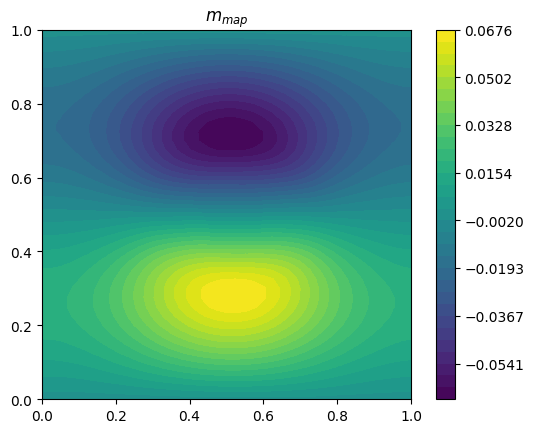

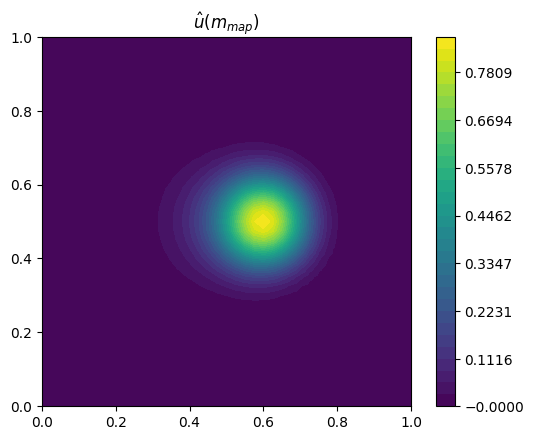

In [5]:
reset_manager()
start_manager()
J_mismatch, _, J, u_map = forward(m_map)
stop_manager()

plot_output(m_map, r"$m_{map}$")
plot_output(u_map, r"$\hat{u} ( m_{map} )$")

## Computing uncertainty estimates: Low rank update approximation

We next seek to use Hessian information to quantify the uncertainty in the result of the inference. We use a low-rank update approximation using the methodology of Isaac et al 2015, doi: 10.1016/j.jcp.2015.04.047.

In this approach we consider the mismatch Hessian, $H_{mismatch}$, obtained by differentiating

$$J_{mismatch} = \frac{1}{2} R_{obs}^{-1} ( u_{obs} - \hat{u}_N ( m ), u_{obs} - \hat{u}_N ( m ) ),$$

twice with respect to the control $m$. i.e.

$$H_{mismatch} = H - B^{-1}.$$

We seek eigenpairs $\lambda_k \in \mathbb{R}$, $v_k \in V$ such that

$$H_{mismatch} \left( v_k, \cdot \right) = \lambda_k B^{-1} \left( v_k, \cdot \right),$$

where the eigenvectors are $B^{-1}$-orthonormal

$$B^{-1} ( v_k, v_l ) = \delta_{k,l}.$$

This leads directly to an expression for a low-rank update approximation for the Hessian inverse, expressed as a low rank update to the prior covariance (equation (20) of Isaac et al 2015, doi: 10.1016/j.jcp.2015.04.047),

$$H^{-1} ( q_i, q_j ) \approx B ( q_i, q_j ) - \sum_k \frac{\lambda_k}{1 + \lambda_k} q_i ( v_k ) q_j ( v_k ),$$

which we use to approximate the posterior covariance.

We first perform a higher order Taylor verification using the mismatch Hessian.

In [6]:
H_mismatch = CachedHessian(J_mismatch)

dm = Function(space, name="dm").interpolate(
    exp(-((X[0] - 0.3) ** 2 + (X[1] - 0.3) ** 2) / (2 * 0.08 * 0.08)))
min_order = taylor_test(lambda m: forward(m)[0], m_map, J_val=J_mismatch.value, ddJ=H_mismatch, dM=dm, seed=1.0e-4)
assert min_order > 2.99

Error norms, no adjoint   = [0.00379075 0.00214381 0.00113403 0.00058255 0.00029516]


Orders,      no adjoint   = [0.82230944 0.91871228 0.96100471 0.98088892]


Error norms, with adjoint = [4.71842950e-07 5.92286109e-08 7.41905819e-09 9.28147120e-10
 1.15956090e-10]


Orders,      with adjoint = [2.99394059 2.99698629 2.99881065 3.00077491]


We now use SLEPc, seeking the 20 eigenpairs whose eigenvalues have largest magnitude.

Note: There is a notational clash here! Conventially the prior inverse covariance is denoted $B^{-1}$, but here we use this on the right-hand-side of a generalized eigenproblem, where the associated matrix is *also* conventially notated $B$. Here the `B_action` argument to the `HessianEigensolver` constructor is set equal to `B_inv_action` in the call, and the `B_inv_action` argument is set equal to `B_action`!

In [7]:
esolver = HessianEigensolver(
    H_mismatch, m_map, B_action=B_inv_action, B_inv_action=B_action,
    solver_parameters={"eps_type": "krylovschur",
                       "eps_gen_hermitian": None,
                       "eps_largest_magnitude": None,
                       "eps_nev": 20,
                       "eps_conv_rel": None,
                       "eps_tol": 1.0e-14,
                       "eps_purify": False,
                       "eps_monitor": None})
esolver.solve()

  Eigenvalue approximations and residual norms for _tlm_adjoint__EPS_0xc4000007_0_ solve.
  1 EPS nconv=10 first unconverged value (error) 208.222 (1.53942626e-13)


  2 EPS nconv=16 first unconverged value (error) 118.459 (3.82528711e-14)


  3 EPS nconv=20 first unconverged value (error) 87.915 (2.00950343e-14)


Let's plot the eigenvalues.

Text(0, 0.5, 'Eigenvalue')

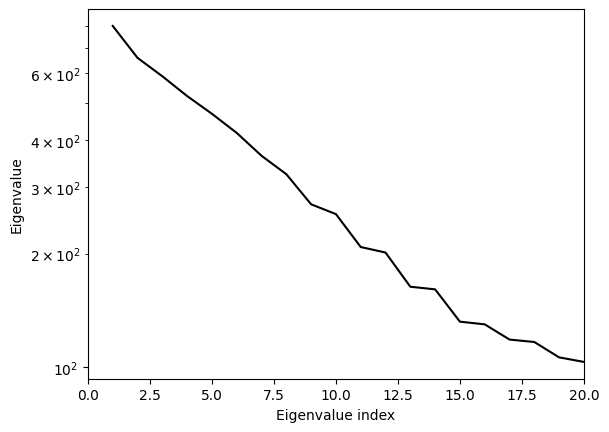

In [8]:
lam = esolver.eigenvalues()
assert (lam > 0.0).all()
plt.semilogy(range(1, len(esolver) + 1), lam, "k-")
plt.xlim(0, len(esolver))
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")

Each eigenvalue indicates some information, added by the observation, over the prior. Specifically each eigenvector $v_k \in V$ has an associated dual space element defined by the prior inverse covariance, $q_{v_k} = B^{-1} ( v_k, \cdot ) \in V^*$. If we have an observation for a quantitity of interest defined by a linear functional equal to a (non-zero) multiple of this associated dual space element, and if the posterior were Gaussian, then the associated variance decreases by a factor of one plus the eigenvalue when we add the observation. That is, under the Gaussian approximation, we have

$$\frac{\sigma^2_{q_{v_k},posterior}}{\sigma^2_{q_{v_k},prior}} = \frac{1}{1 + \lambda_k},$$

where $\sigma^2_{q_{v_k},posterior}$ and $\sigma^2_{q_{v_k},prior}$ are respectively the posterior and prior variance associated with $q_{v_k}$, and where $\lambda_k$ is the associated eigenvalue.

Having retained only $20$ eigenpairs, the smallest eigenvalue obtained is quite a bit bigger than one. This means we might expect to be missing quite a bit of information available in the Hessian if we use a low rank update approximation using only these $20$ eigenpairs. We'll return to this issue later.

The linear functional associated with computing the average $x$-component of the velocity for $0.4 < y < 0.6$, $q_u \in V^*$, satisfies

$$q_u ( \zeta ) = -\frac{1}{\int_\Omega \mathcal{I}} \int_\Omega \mathcal{I} \partial_y \zeta,$$

where $\mathcal{I}$ is one where $0.4 < y < 0.6$ and zero elsewhere. We can use this to evaluate an estimate for the posterior mean of this quantity,

$$\mu_{q_u,posterior} \approx q_u ( m_{map} ).$$

In [9]:
I = Function(FunctionSpace(mesh, "Discontinuous Lagrange", 0)).interpolate(
    conditional(X[1] > 0.4, 1.0, 0.0) * conditional(X[1] < 0.6, 1.0, 0.0))
q_u = assemble(-(1 / Constant(assemble(I * dx))) * I * test.dx(1) * dx)
print(f"{assemble(q_u(m_map))=}")

assemble(q_u(m_map))=0.26603362165200495


The associated posterior uncertainty estimate is then

$$\sigma_{q_u,posterior} \approx \sqrt{H_{approx}^{-1} ( q_u, q_u )}.$$

In [10]:
sigma_u = sqrt(assemble(q_u(esolver.spectral_approximation_solve(q_u))))
print(f"{sigma_u=}")

sigma_u=0.049826943093325984


We can compare this with the prior uncertainty,

$$\sigma_{q_u,prior} = \sqrt{ B ( q_u, q_u ) }.$$

In [11]:
sigma_prior_q_u = sqrt(assemble(q_u(B_action(q_u))))
print(f"{sigma_prior_q_u=}")

sigma_prior_q_u=0.06809389996419146


i.e. we estimate that the observation has reduced the uncertainty in our estimate for $q_u( m )$ by about 25%.

## Computing uncertainty estimates: Full Hessian inverse

We have made a number of assumptions in order to define the inference problem, but given the problem we have used only two approximations in the uncertainty estimate itself: the local Gaussian assumption (making use of the Hessian), and the low rank update approximation for the Hessian inverse. We now remove the second of these approximations using a Krylov solver, using PETSc. Since we already have an *approximation* for the Hessian inverse, we can use this to construct a preconditioner in the calculation of a Hessian inverse action.

In [12]:
H = CachedHessian(J)

ksp = HessianLinearSolver(H, m_map, solver_parameters={"ksp_type": "cg",
                                                       "ksp_atol": 0.0,
                                                       "ksp_rtol": 1.0e-7,
                                                       "ksp_monitor": None},
                          pc_fn=esolver.spectral_pc_fn())
H_inv_q_u = Function(space, name="H_inv_q_u")
ksp.solve(H_inv_q_u, q_u)

  Residual norms for _tlm_adjoint__KSP_0xc4000009_0_ solve.
  0 KSP Residual norm 9.901063940612e-03


  1 KSP Residual norm 3.846887396923e-03


  2 KSP Residual norm 2.959402172924e-03


  3 KSP Residual norm 1.718696050315e-03


  4 KSP Residual norm 1.325055699763e-03


  5 KSP Residual norm 1.122277413445e-03


  6 KSP Residual norm 9.690002941905e-04


  7 KSP Residual norm 8.439140190241e-04


  8 KSP Residual norm 3.525862866587e-04


  9 KSP Residual norm 5.477244753569e-04


 10 KSP Residual norm 3.121835833383e-04


 11 KSP Residual norm 3.134450820882e-04


 12 KSP Residual norm 2.941740579930e-04


 13 KSP Residual norm 1.381997473824e-04


 14 KSP Residual norm 2.289384303399e-04


 15 KSP Residual norm 1.076096378952e-04


 16 KSP Residual norm 5.271734235858e-05


 17 KSP Residual norm 5.616047775553e-05


 18 KSP Residual norm 5.265159239080e-05


 19 KSP Residual norm 2.521783658860e-05


 20 KSP Residual norm 1.637758855716e-05


 21 KSP Residual norm 3.058528737786e-05


 22 KSP Residual norm 1.532049998254e-05


 23 KSP Residual norm 7.979585813705e-06


 24 KSP Residual norm 1.027004717719e-05


 25 KSP Residual norm 5.229044836309e-06


 26 KSP Residual norm 6.839842962128e-06


 27 KSP Residual norm 4.015886996091e-06


 28 KSP Residual norm 4.402673928099e-06


 29 KSP Residual norm 3.292276914745e-06


 30 KSP Residual norm 2.419410043024e-06


 31 KSP Residual norm 9.394867583164e-07


 32 KSP Residual norm 1.217609278977e-06


 33 KSP Residual norm 2.039049206921e-06


 34 KSP Residual norm 9.341725889835e-07


 35 KSP Residual norm 2.811449319662e-07


 36 KSP Residual norm 4.402614113737e-07


 37 KSP Residual norm 2.961624710683e-07


 38 KSP Residual norm 1.687143968444e-07


 39 KSP Residual norm 1.890661648698e-07


 40 KSP Residual norm 9.740610911599e-08


 41 KSP Residual norm 8.977497357935e-08


 42 KSP Residual norm 7.347374434350e-08


 43 KSP Residual norm 6.582416229412e-08


 44 KSP Residual norm 5.382757249658e-08


 45 KSP Residual norm 6.341360847130e-08


 46 KSP Residual norm 3.470665801808e-08


 47 KSP Residual norm 3.227599902138e-08


 48 KSP Residual norm 1.958410568715e-08


 49 KSP Residual norm 2.301198958079e-08


 50 KSP Residual norm 1.846709667676e-08


 51 KSP Residual norm 1.827263291620e-08


 52 KSP Residual norm 1.189008861456e-08


 53 KSP Residual norm 1.077867596364e-08


 54 KSP Residual norm 7.471548333104e-09


 55 KSP Residual norm 7.808925136195e-09


 56 KSP Residual norm 7.444404082607e-09


 57 KSP Residual norm 4.851473640139e-09


 58 KSP Residual norm 3.990201734499e-09


 59 KSP Residual norm 3.497153443461e-09


 60 KSP Residual norm 3.159027163400e-09


 61 KSP Residual norm 2.518510686472e-09


 62 KSP Residual norm 1.782610592870e-09


 63 KSP Residual norm 1.313695279622e-09


 64 KSP Residual norm 1.090144383730e-09


 65 KSP Residual norm 6.928084128271e-10


Let's double check that we solved the linear system.

In [13]:
residual = Cofunction(space.dual()).assign(
    H.action(m_map, H_inv_q_u)[2] - q_u)
q_u_norm = abs(q_u.dat.data_ro).max()
residual_norm = abs(residual.dat.data_ro).max()
print(f"{residual_norm / q_u_norm=}")
assert residual_norm / q_u_norm < 1.0e-4

residual_norm / q_u_norm=np.float64(1.608633886866077e-05)


Our new uncertainty estimate, using the full Hessian, is

In [14]:
sigma_u = sqrt(assemble(q_u(H_inv_q_u)))
print(f"{sigma_u=}")

sigma_u=0.031200525962623942


This reveals that our partial eigenspectrum estimate did indeed miss quite a bit of relevant information available in the Hessian. In fact with the full Hessian we estimate a reduction in uncertainty of about 55%.